Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


First reload the data we generated in `1_notmnist.ipynb`.

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f) #,encoding='latin1')
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (448297, 28, 28) (448297,)
Validation set (13649, 28, 28) (13649,)
Test set (13649, 28, 28) (13649,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (448297, 784) (448297, 10)
Validation set (13649, 784) (13649, 10)
Test set (13649, 784) (13649, 10)


In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

## Add L2 Loss to Logistic Regression Graph

In [6]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    tf_beta = tf.placeholder(tf.float32,shape=())

    # Variables.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    loss += tf_beta*tf.nn.l2_loss(weights)

    # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
betas = np.exp(np.arange(np.log(0.003),np.log(0.01),0.1))
print(betas)

[ 0.003       0.00331551  0.00366421  0.00404958  0.00447547  0.00494616
  0.00546636  0.00604126  0.00667662  0.00737881  0.00815485  0.0090125
  0.00996035]


In [11]:
num_steps = 5001

test_accuracy = list()

# config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )

with tf.Session(graph=graph) as session:
    for beta in betas:
        tf.global_variables_initializer().run()
        print("Initialized")

        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = { tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta : beta }
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(
                    valid_prediction.eval(), valid_labels))
        
        test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
        print("Beta: {}, Test accuracy: {}%".format(beta, test_accuracy[-1]))
        


Initialized
Minibatch loss at step 0: 28.597992
Minibatch accuracy: 6.2%
Validation accuracy: 5.8%
Minibatch loss at step 500: 11.448461
Minibatch accuracy: 62.5%
Validation accuracy: 62.4%
Minibatch loss at step 1000: 7.647367
Minibatch accuracy: 76.6%
Validation accuracy: 69.9%
Minibatch loss at step 1500: 6.464865
Minibatch accuracy: 77.3%
Validation accuracy: 72.7%
Minibatch loss at step 2000: 4.514636
Minibatch accuracy: 71.9%
Validation accuracy: 74.4%
Minibatch loss at step 2500: 3.475236
Minibatch accuracy: 74.2%
Validation accuracy: 75.8%
Minibatch loss at step 3000: 2.368566
Minibatch accuracy: 80.5%
Validation accuracy: 77.4%
Minibatch loss at step 3500: 1.888000
Minibatch accuracy: 80.5%
Validation accuracy: 78.5%
Minibatch loss at step 4000: 1.501263
Minibatch accuracy: 79.7%
Validation accuracy: 79.5%
Minibatch loss at step 4500: 1.101243
Minibatch accuracy: 83.6%
Validation accuracy: 80.5%
Minibatch loss at step 5000: 0.915338
Minibatch accuracy: 82.8%
Validation accurac

KeyboardInterrupt: 

**Finding the value of beta that provides maximum accuracy**

Beta: 0.00546635640117 corresponds to a maximum test accuracy of 89.26%


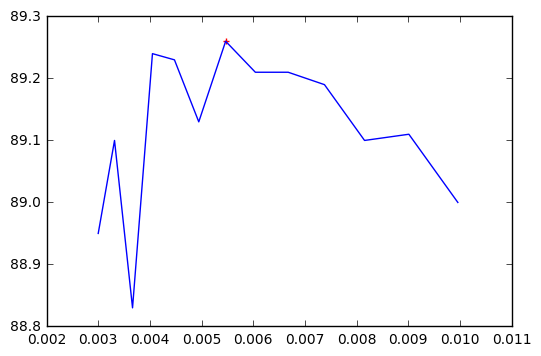

In [142]:
from matplotlib import pyplot as plt
plt.plot(betas,test_accuracy)
maximum = np.array(test_accuracy).argmax()
print ("Beta: {} corresponds to a maximum test accuracy of {}%".format(betas[maximum],test_accuracy[maximum]))
plt.scatter(betas[maximum],test_accuracy[maximum],marker='+',c='r')

## Add L2 Loss to Neural Network

In [12]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32,shape=())

    # Variables.
    weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    weights_2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    logits = tf.matmul(layer_1, weights_2) + biases_2
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    loss += tf_beta*tf.nn.l2_loss(weights_1)
    loss += tf_beta*tf.nn.l2_loss(weights_2)
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    valid_prediction = tf.nn.softmax(
    tf.matmul(layer_1_valid, weights_2) + biases_2)
    layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    test_prediction = tf.nn.softmax(
    tf.matmul(layer_1_test, weights_2) + biases_2)

In [13]:
betas = np.exp(np.arange(np.log(0.0001),np.log(0.1),1))
print(betas)

[ 0.0001      0.00027183  0.00073891  0.00200855  0.00545982  0.01484132
  0.04034288]


In [15]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta: beta}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    test_accuracy = accuracy(test_prediction.eval(), test_labels)


            
    print("Beta: {}, Test accuracy: {}%".format(beta, test_accuracy))

Initialized
Minibatch loss at step 0: 1622.224854
Minibatch accuracy: 4.7%
Validation accuracy: 7.1%
Minibatch loss at step 500: 1014.183228
Minibatch accuracy: 73.4%
Validation accuracy: 77.1%
Minibatch loss at step 1000: 808.248596
Minibatch accuracy: 86.7%
Validation accuracy: 78.4%
Minibatch loss at step 1500: 650.081726
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 2000: 508.139771
Minibatch accuracy: 80.5%
Validation accuracy: 80.9%
Minibatch loss at step 2500: 396.293854
Minibatch accuracy: 78.1%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 300.173889
Minibatch accuracy: 82.8%
Validation accuracy: 82.5%
Beta: 0.00366420827448, Test accuracy: 82.7535439364%


**Finding the value of beta that provides maximum accuracy**

In [16]:
from matplotlib import pyplot as plt
plt.plot(betas,test_accuracy)
maximum = np.array(test_accuracy).argmax()
print ("Beta: {} corresponds to a maximum test accuracy of {}%".format(betas[maximum],test_accuracy[maximum]))
plt.scatter(betas[maximum],test_accuracy[maximum],marker='+',c='r')

ValueError: x and y must have same first dimension

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [18]:
num_steps = 3001
test_accuracy = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (3*batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta: beta}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
    print("Beta: {}, Test accuracy: {}%".format(beta, test_accuracy[-1]))

Initialized
Minibatch loss at step 0: 1465.838867
Minibatch accuracy: 18.0%
Validation accuracy: 14.9%
Minibatch loss at step 500: 844.361572
Minibatch accuracy: 100.0%
Validation accuracy: 52.5%
Minibatch loss at step 1000: 498.843414
Minibatch accuracy: 100.0%
Validation accuracy: 48.3%
Minibatch loss at step 1500: 256.384125
Minibatch accuracy: 100.0%
Validation accuracy: 45.8%
Minibatch loss at step 2000: 116.510010
Minibatch accuracy: 100.0%
Validation accuracy: 44.8%
Minibatch loss at step 2500: 47.601383
Minibatch accuracy: 100.0%
Validation accuracy: 46.2%
Minibatch loss at step 3000: 18.327129
Minibatch accuracy: 100.0%
Validation accuracy: 51.9%
Beta: 0.00366420827448, Test accuracy: 52.1516005553%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [19]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32,shape=())

    # Variables.
    weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    weights_2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases_1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
    dropout_1 = tf.nn.dropout(layer_1, 0.5)
    logits = tf.matmul(dropout_1, weights_2) + biases_2
    dropout_logits = tf.nn.dropout(logits, 0.5)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(dropout_logits, tf_train_labels))

#     loss += tf_beta*tf.nn.l2_loss(weights_1)
#     loss += tf_beta*tf.nn.l2_loss(weights_2)
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    layer_1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
    valid_prediction = tf.nn.softmax(
    tf.matmul(layer_1_valid, weights_2) + biases_2)
    layer_1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
    test_prediction = tf.nn.softmax(
    tf.matmul(layer_1_test, weights_2) + biases_2)

In [20]:
num_steps = 3001
test_accuracy = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (10*batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta: beta}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
    print("Beta: {}, Test accuracy: {}%".format(beta, test_accuracy[-1]))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 686.051147
Minibatch accuracy: 13.3%
Validation accuracy: 10.9%
Minibatch loss at step 500: 47.416645
Minibatch accuracy: 83.6%
Validation accuracy: 78.1%
Minibatch loss at step 1000: 23.608555
Minibatch accuracy: 91.4%
Validation accuracy: 79.3%
Minibatch loss at step 1500: 16.758583
Minibatch accuracy: 94.5%
Validation accuracy: 79.7%
Minibatch loss at step 2000: 2.331586
Minibatch accuracy: 97.7%
Validation accuracy: 79.9%
Minibatch loss at step 2500: 2.009538
Minibatch accuracy: 97.7%
Validation accuracy: 79.8%
Minibatch loss at step 3000: 5.666512
Minibatch accuracy: 96.1%
Validation accuracy: 80.1%
Beta: 0.00366420827448, Test accuracy: 80.1749884323%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [41]:
%%time

batch_size = 128
num_hidden_nodes = 1024

nodes_per_layer = [image_size*image_size, num_labels*3**5, num_labels*3**4, num_labels*3**3, num_labels*3**2, num_labels*3**1, num_labels]
print(nodes_per_layer)

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_regularisation_beta = tf.placeholder(tf.float32)
    tf_keep_prob = tf.placeholder(tf.float32)

    # Variables. 
    weights = list()
    biases = list()   
    for this_nodes, that_nodes in zip(nodes_per_layer[:-1],nodes_per_layer[1:]):
        weights.append(tf.Variable(tf.truncated_normal([this_nodes, that_nodes],stddev=np.sqrt(2.0/this_nodes))))
        biases.append(tf.Variable(tf.zeros([that_nodes])))
    
    def logits(tf_dataset):
        layers = list()
        previous_layer = tf_dataset
        
        # Input layer
        for this_weights,this_biases in zip(weights,biases):
            this_logits = tf.matmul(previous_layer, this_weights) + this_biases
            
            # All except the last layer
            if len(layers) < len(weights)-1:
                layers.append(tf.nn.elu(this_logits))

                # Only for hidden layers
                if len(layers) > 1:
                    layers[-1] = tf.nn.dropout(layers[-1], tf_keep_prob)
                else:
                    print('Skipping dropout on first layer.')
                previous_layer = layers[-1]
            else:
                print('Skipping elu and dropout on last layer.')
        
        return this_logits

    train_logits = logits(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits, tf_train_labels))
    loss += tf_regularisation_beta * tf.nn.l2_loss(train_logits)
   
    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.1, global_step, 4000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(train_logits)
    valid_prediction = tf.nn.softmax(logits(tf_valid_dataset))
    test_prediction = tf.nn.softmax(logits(tf_test_dataset))
    
from sklearn.metrics import confusion_matrix
num_steps = 30001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0]-batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_keep_prob: 0.75, tf_regularisation_beta : 1e-5}
        _, l, minibatch_prediction = session.run(fetches=[optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(minibatch_prediction, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(feed_dict={tf_keep_prob: 1.0}), valid_labels))
    test_predictions = test_prediction.eval(feed_dict={tf_keep_prob: 1.0})
    test_accuracy = accuracy(test_predictions, test_labels)
    print("Test accuracy: %.1f%%" % test_accuracy)
    cat_test_label = np.argmax(test_labels,1)
    cat_test_pred = np.argmax(test_predictions,1)
    print(confusion_matrix(cat_test_label,cat_test_pred))

[784, 2430, 810, 270, 90, 30, 10]
Skipping dropout on first layer.
Skipping elu and dropout on last layer.
Skipping dropout on first layer.
Skipping elu and dropout on last layer.
Skipping dropout on first layer.
Skipping elu and dropout on last layer.
Initialized
Minibatch loss at step 0: 2.710750
Minibatch accuracy: 12.5%
Validation accuracy: 27.8%
Minibatch loss at step 500: 0.721380
Minibatch accuracy: 80.5%
Validation accuracy: 83.1%
Minibatch loss at step 1000: 0.706303
Minibatch accuracy: 77.3%
Validation accuracy: 84.0%
Minibatch loss at step 1500: 0.612950
Minibatch accuracy: 84.4%
Validation accuracy: 84.8%
Minibatch loss at step 2000: 0.678616
Minibatch accuracy: 81.2%
Validation accuracy: 85.5%
Minibatch loss at step 2500: 0.490336
Minibatch accuracy: 85.9%
Validation accuracy: 85.8%
Minibatch loss at step 3000: 0.439175
Minibatch accuracy: 88.3%
Validation accuracy: 86.4%
Minibatch loss at step 3500: 0.457466
Minibatch accuracy: 89.8%
Validation accuracy: 86.9%
Minibatch l

## Common mistake inspection

False predictions 614
Total number of test labels 13649
Fraction incorrect 0.0449849805847


<IPython.core.display.Javascript object>


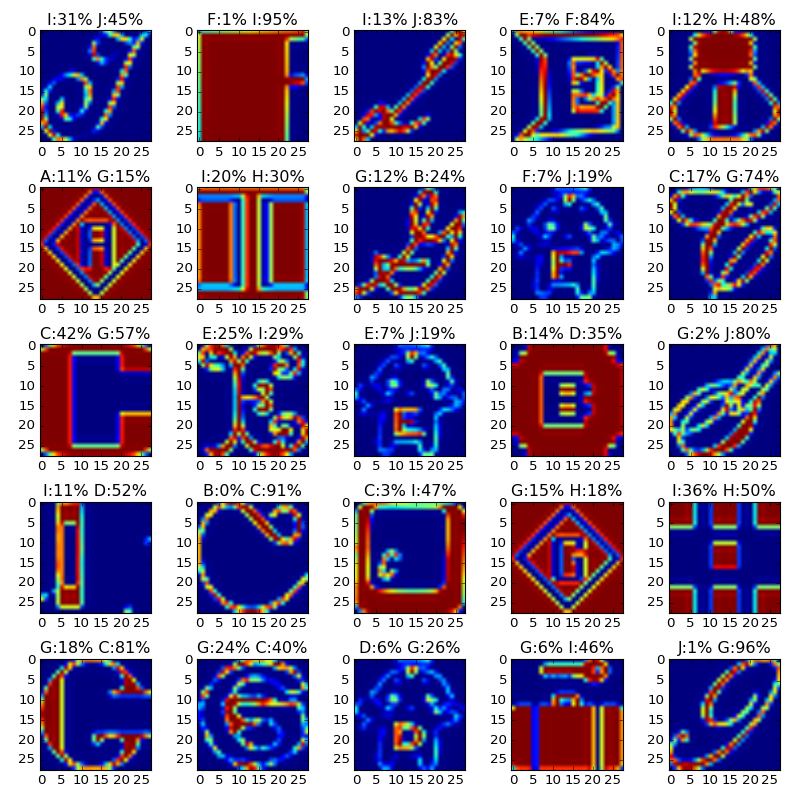

In [37]:
false_predictions, = np.where(cat_test_label!=cat_test_pred)
print ('False predictions',len(false_predictions))
print ('Total number of test labels',len(cat_test_label))
print ('Fraction incorrect', float(len(false_predictions))/len(cat_test_label))

idx2chr = lambda x: chr(x+65)
offset = 500
plt.figure(figsize=(10,10))
gridsize = 5
for i,fp in enumerate(false_predictions[offset:offset+gridsize**2]):
    plt.subplot(gridsize,gridsize,i+1)
    label_idx = cat_test_label[fp]
    pred_idx = cat_test_pred[fp]
    plt.title("{}:{:0.0f}% {}:{:0.0f}%".format(idx2chr(label_idx),test_predictions[fp,label_idx]*100,idx2chr(pred_idx),test_predictions[fp,pred_idx]*100))
    plt.imshow(test_dataset[fp].reshape((28,28)))
plt.tight_layout()


## Endri Deliu's code from [Udacity](https://discussions.udacity.com/t/assignment-4-problem-2/46525/26?u=brtknr) which yields 95.3% on test dataset in 30000 steps

In [42]:
%%time

batch_size = 128
hidden_layer1_size = 1024
hidden_layer2_size = 305
hidden_lastlayer_size = 75

use_multilayers = True

regularization_beta=0.03


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  keep_prob = tf.placeholder(tf.float32)

  weights_layer1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_layer1_size], stddev=0.0517))
  biases_layer1 = tf.Variable(tf.zeros([hidden_layer1_size]))

  if use_multilayers:
    weights_layer2 = tf.Variable(
      tf.truncated_normal([hidden_layer1_size, hidden_layer1_size], stddev=0.0441))
    biases_layer2 = tf.Variable(tf.zeros([hidden_layer1_size]))

    weights_layer3 = tf.Variable(
      tf.truncated_normal([hidden_layer1_size, hidden_layer2_size], stddev=0.0441))
    biases_layer3 = tf.Variable(tf.zeros([hidden_layer2_size]))
    
    weights_layer4 = tf.Variable(
      tf.truncated_normal([hidden_layer2_size, hidden_lastlayer_size], stddev=0.0809))
    biases_layer4 = tf.Variable(tf.zeros([hidden_lastlayer_size]))


  weights = tf.Variable(
    tf.truncated_normal([hidden_lastlayer_size if use_multilayers else hidden_layer1_size, num_labels], stddev=0.1632))
  biases = tf.Variable(tf.zeros([num_labels]))
  
    
  # get the NN models
  def getNN4Layer(dSet, use_dropout):
    input_to_layer1 = tf.matmul(dSet, weights_layer1) + biases_layer1
    hidden_layer1_output = tf.nn.elu(input_to_layer1)
    
    
    logits_hidden1 = None
    if use_dropout:
       dropout_hidden1 = tf.nn.dropout(hidden_layer1_output, keep_prob)
       logits_hidden1 = tf.matmul(dropout_hidden1, weights_layer2) + biases_layer2
    else:
      logits_hidden1 = tf.matmul(hidden_layer1_output, weights_layer2) + biases_layer2
    
    hidden_layer2_output = tf.nn.elu(logits_hidden1)
    
    logits_hidden2 = None
    if use_dropout:
       dropout_hidden2 = tf.nn.dropout(hidden_layer2_output, keep_prob)
       logits_hidden2 = tf.matmul(dropout_hidden2, weights_layer3) + biases_layer3
    else:
      logits_hidden2 = tf.matmul(hidden_layer2_output, weights_layer3) + biases_layer3
    
    
    hidden_layer3_output = tf.nn.elu(logits_hidden2)
    logits_hidden3 = None
    if use_dropout:
       dropout_hidden3 = tf.nn.dropout(hidden_layer3_output, keep_prob)
       logits_hidden3 = tf.matmul(dropout_hidden3, weights_layer4) + biases_layer4
    else:
      logits_hidden3 = tf.matmul(hidden_layer3_output, weights_layer4) + biases_layer4
    
    
    hidden_layer4_output = tf.nn.elu(logits_hidden3)
    logits = None
    if use_dropout:
       dropout_hidden4 = tf.nn.dropout(hidden_layer4_output, keep_prob)
       logits = tf.matmul(dropout_hidden4, weights) + biases
    else:
      logits = tf.matmul(hidden_layer4_output, weights) + biases
    
    return logits

  # get the NN models
  def getNN1Layer(dSet, use_dropout, w1, b1, w, b):
    input_to_layer1 = tf.matmul(dSet, w1) + b1
    hidden_layer1_output = tf.nn.elu(input_to_layer1)
        
    logits = None
    if use_dropout:
       dropout_hidden1 = tf.nn.dropout(hidden_layer1_output, keep_prob)
       logits = tf.matmul(dropout_hidden1, w) + b
    else:
      logits = tf.matmul(hidden_layer1_output, w) + b
    
    return logits

  
  
  # Training computation.
  logits = getNN4Layer(tf_train_dataset, True)  
  logits_valid = getNN4Layer(tf_valid_dataset, False)
  logits_test = getNN4Layer(tf_test_dataset, False)
    
  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  #loss_l2 = loss + (regularization_beta * (tf.nn.l2_loss(weights)))
  
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.3, global_step, 3500, 0.86, staircase=True)
  
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(logits_valid)
  test_prediction = tf.nn.softmax(logits_test)

num_steps = 30001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print ("Initialized")
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob:0.75}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print ("Minibatch loss at step", step, ":", l)
      print ("Minibatch accuracy: %.1f%%" % accuracy(train_prediction.eval(feed_dict={tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob:1.0}), batch_labels))
      print ("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(feed_dict={keep_prob:1.0}), valid_labels))
  print ("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict={keep_prob:1.0}), test_labels))

Initialized
Minibatch loss at step 0 : 2.8688
Minibatch accuracy: 63.3%
Validation accuracy: 39.9%
Minibatch loss at step 500 : 0.673491
Minibatch accuracy: 87.5%
Validation accuracy: 82.8%
Minibatch loss at step 1000 : 0.617919
Minibatch accuracy: 85.2%
Validation accuracy: 83.7%
Minibatch loss at step 1500 : 0.557346
Minibatch accuracy: 85.9%
Validation accuracy: 84.9%
Minibatch loss at step 2000 : 0.654382
Minibatch accuracy: 87.5%
Validation accuracy: 84.9%
Minibatch loss at step 2500 : 0.540959
Minibatch accuracy: 89.8%
Validation accuracy: 85.3%
Minibatch loss at step 3000 : 0.452396
Minibatch accuracy: 91.4%
Validation accuracy: 86.3%
Minibatch loss at step 3500 : 0.445844
Minibatch accuracy: 89.8%
Validation accuracy: 86.1%
Minibatch loss at step 4000 : 0.637189
Minibatch accuracy: 88.3%
Validation accuracy: 86.3%
Minibatch loss at step 4500 : 0.656776
Minibatch accuracy: 86.7%
Validation accuracy: 86.9%
Minibatch loss at step 5000 : 0.450459
Minibatch accuracy: 91.4%
Validatio